## This notebook trains attention-based multiple instance learning classifier of the zerbafish embryos. The code allows training of a model with one of the three alternative backbones: MobileNetV2, ResNet50 and a shalllow convolutional network. After training, classifier's accuracy is evaluated and attention distribution is analyzed for each class. For evaluation of the attention given to the different parts of the fish, the code uses masks which denote the areas of main fish parts for images in the validation set.

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm 
import tensorflow as tf
import cv2
from PIL import Image
import seaborn as sns
import shutil
import os
import tensorflow_datasets as tfds   
from skimage.transform import resize
from skimage.draw import line_nd
from sklearn import metrics
import pandas as pd
import glob
plt.rcParams["axes.grid"] = False
import scipy
from imageio import imread
from keras.preprocessing.image import ImageDataGenerator
from collections import Counter
from pathlib import Path

### Loading the zebrafish data

In [8]:
path_train = Path("training")
path_val = Path("validation")

train_datagen_augmented = ImageDataGenerator(rescale = 1.0/255., brightness_range = (0.7, 1.3), rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip = True)
val_datagen = ImageDataGenerator( rescale = 1.0/255. ) #no augmentation

data_train = train_datagen_augmented.flow_from_directory(path_train, batch_size = 16, class_mode = 'sparse', target_size = (450, 900))
data_test = val_datagen.flow_from_directory(path_val,  batch_size = 16, class_mode = 'sparse', target_size = (450, 900))

x,y = data_train.next()

Found 398 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


### Building and compiling the model

In [17]:
def build_model(shape, backbone="mobilenet"):
    inp = tf.keras.Input(shape=shape)
    print(backbone)

    if backbone=="mobilenet":
        model_pretrained = tf.keras.applications.MobileNetV2(
            input_shape=shape, include_top=False, weights='imagenet')
        model_pretrained.trainable = False
        features = model_pretrained(inp, training=False)
        #features = model_pretrained(inp)
    
    elif backbone=="resnet":
        model_pretrained = tf.keras.applications.ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=shape)
        # get the output after the 4th round of resnet blocks, which happens to be layer 142 
        lay_middle = [lay for lay in model_pretrained.layers if "conv3_block4_out" in lay.name][0]
        model_pretrained = tf.keras.Model(model_pretrained.input, lay_middle.output)
        features = model_pretrained(inp)
        
    elif backbone=="conv":
        x = inp
        for _ in range(3):
            x = tf.keras.layers.Conv2D(32,3,activation="relu", padding="same")(x)
            x = tf.keras.layers.Conv2D(32,3,activation="relu", padding="same")(x)
            x = tf.keras.layers.MaxPooling2D((2,2))(x)
        features = x
    else:
        raise NotImplementedError(backbone)

    
    features = tf.keras.layers.Conv2D(64, 1, padding="same", activation="relu")(features)

    # attention mask
    # two small depth wise convolutions

    attention = tf.keras.layers.Conv2D(64,1, padding="same", activation="tanh")(features)
    attention = tf.keras.layers.Conv2D(1,1, padding="same", activation="linear")(attention)
    # make sure that it sums to one...
    shape = attention.get_shape().as_list()        
    attention = tf.keras.layers.Flatten()(attention)
    attention = tf.math.softmax(attention)
    attention = tf.keras.layers.Reshape(shape[1:])(attention)
    # multiply by normalized attention 
    x = tf.multiply(features, attention)
    x = tf.math.reduce_sum(x, axis=(1,2)) #attention
    #x = tf.math.reduce_mean(features, axis=(1,2)) #no attention
    model_attention = tf.keras.Model(inp, attention)

    x = tf.keras.layers.Dropout(0.2)(x)
    out = tf.keras.layers.Dense(4,)(x)#, activation='softmax'? No, because we use "from_logits = True". VG

    model = tf.keras.Model(inp, out)
    return model, model_attention
    
model, model_attention = build_model(x.shape[1:], backbone="mobilenet")

rate = 5e-4
epochs = 100
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    
model.summary()  

mobilenet
Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 450, 900, 3) 0                                            
__________________________________________________________________________________________________
mobilenetv2_1.00_224 (Functiona (None, 15, 29, 1280) 2257984     input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 15, 29, 64)   81984       mobilenetv2_1.00_224[0][0]       
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 15, 29, 64)   4160        conv2d_12[0][0]                  
____________________________________________________________________________

### Training the model

In [18]:
checkpoint_folder = Path('checkpoints')
checkpoint_filepath = checkpoint_folder/"MIL_classifier"

#preparing the weights for balanced training
counts = Counter(data_train.classes)
counts_total = sum(counts.values())
class_weights = dict((k, counts_total/v) for k,v in counts.items())


model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(data_train,validation_data=data_test,epochs=epochs, callbacks=[model_checkpoint_callback], class_weight = class_weights)
np.save(checkpoint_folder/f"MIL_lr_{rate:.4f}_epochs_{epochs}.npy",history.history)

Epoch 1/100


KeyboardInterrupt: 

### Loading the best-epoch weights of the trained model

In [14]:
model, model_attention = build_model(x.shape[1:], backbone="mobilenet")
model.load_weights(checkpoint_filepath)
model_attention.load_weights(checkpoint_filepath)

mobilenet


### Loading history and plot learning curves

In [19]:
history=np.load(checkpoint_folder/f"MIL_lr_{rate:.4f}_epochs_{epochs}.npy",allow_pickle='TRUE').item()

acc = history['sparse_categorical_accuracy']
val_acc = history['val_sparse_categorical_accuracy']

loss = history['loss']
val_loss = history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.ylim([min(plt.ylim()),1.05])
plt.title('Training and Validation Accuracy')

FileNotFoundError: [Errno 2] No such file or directory: 'checkpoints\\MIL_lr_0.0005_epochs_100.npy'

### Show a few examples of the attention mask

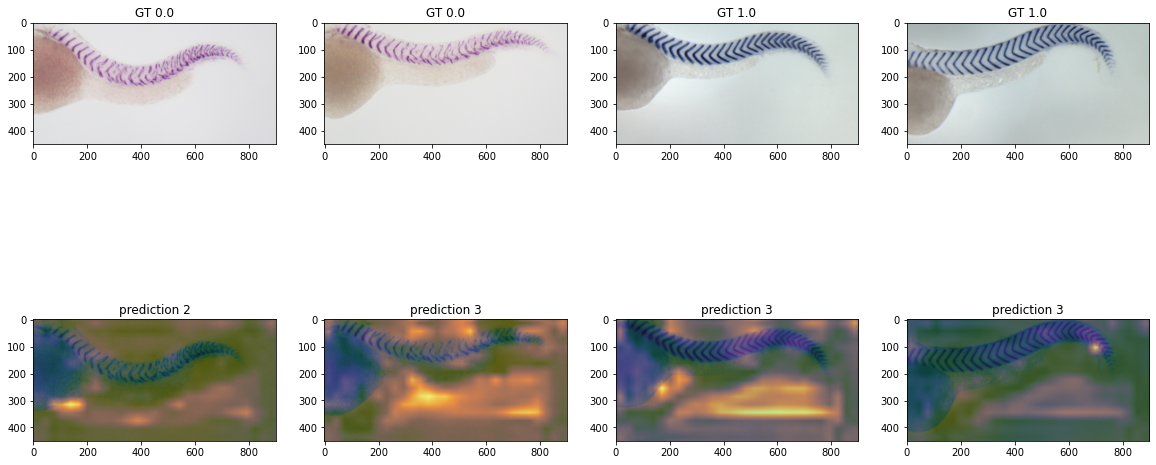

In [20]:
x, y = next(data_test)

pred = np.argmax(model.predict(x), axis=-1)
att = model_attention.predict(x)
n_plot= 4
plt.figure(figsize=(20,10))
for i,(_x,_y,_p, _a) in enumerate(zip(x[:n_plot],y[:n_plot], pred[:n_plot], att[:n_plot])):
    plt.subplot(2,n_plot,i+1)
    plt.imshow(_x)
    plt.title(f"GT {_y}")    
    plt.subplot(2,n_plot,n_plot+i+1)

    plt.imshow(_x[...,0])    
    plt.imshow(resize(_a,_x.shape[:2])[:,:,0], alpha=.6, cmap = 'magma')
    plt.title(f"prediction {_p}")

### Calculating the confusion matrix

Found 80 images belonging to 4 classes.
0.225


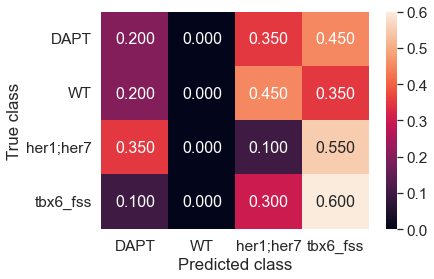

In [23]:
data_test = val_datagen.flow_from_directory(path_val,  batch_size = 16, class_mode = 'sparse', target_size = (450, 900))

true = list() #list of true labels
predicted = list() #list of predicted labels

for i in range(len(data_test)):
    x, y = data_test.next()
    for j in range(len(x)):
        y_pred = np.argmax(model.predict(x[j:j+1]), axis=-1)
        att = model_attention.predict(x[j:j+1])
        
        y_true = y[j]
        
        true.append(y_true)
        predicted.append(y_pred)
        
        
classes = []
for cl in data_test.class_indices:
    classes.append(cl)
    
def calculate_confusion_matrix(classes, true, predicted):
    matrix = metrics.confusion_matrix(true, predicted) #rows - true, columns - predicted
    matrix = matrix.astype(float)

    accuracy = sum(np.diag(matrix))/sum(sum(matrix))
    print(accuracy) 


    for i in range(len(matrix)): #scaling per row (per true label)
        matrix[:][i] = matrix[:][i] / sum(matrix[:][i])
    return matrix, accuracy

[matrix, accuracy] = calculate_confusion_matrix(classes, true, predicted)


df_cm = pd.DataFrame(matrix, index=[classes[0], classes[1], classes[2], classes[3]], columns=[classes[0], classes[1], classes[2], classes[3]])
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='1.3f')# font size
plt.ylabel("True class")
plt.xlabel("Predicted class") 
plt.show()

### Calculating attention for all images and saving validation set images with attention overlayed

Found 80 images belonging to 4 classes.
DAPT\20190425_1_50MDAPT_11.png
DAPT\20190425_1_50MDAPT_13.png
DAPT\20190425_1_50MDAPT_14.png
DAPT\20190425_1_50MDAPT_3.png
DAPT\20190425_2_50MDAPT_1.png
DAPT\20190425_2_50MDAPT_15.png
DAPT\20190425_2_50MDAPT_17.png
DAPT\20190425_2_50MDAPT_9.png
DAPT\20190425_3_50MDAPT_11.png
DAPT\20190425_3_50MDAPT_16.png
DAPT\20190425_3_50MDAPT_22.png
DAPT\20190425_3_50MDAPT_6.png
DAPT\2_DAPT50ISC_24_7.png
DAPT\2_DAPT50M_11.png
DAPT\2_DAPT50M_12.png
DAPT\3_DAPT50ISC_24_7.png
DAPT\3_DAPT50M_13.png
DAPT\3_DAPT50M_7.png
DAPT\4_DAPT50ISC_24_2.png
DAPT\4_DAPT50ISC_24_4.png


C:\Users\gligorov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


WT\160125_ID1-1_1..png
WT\160125_ID1-1_7..png
WT\160125_ID1-1_9..png
WT\160125_ID3-1_3.png
WT\160125_ID3-1_5..png
WT\160125_ID3-5_19..png
WT\160125_ID3-6_10.png
WT\160125_ID3-6_7.png
WT\20171008_B7.png
WT\20190425_2_DMSO_2.png
WT\20190425_3_DMSO_4.png
WT\20190425_3_FW_1.png
WT\20190427_fss_wt6.png
WT\2_DMSO_6.png
WT\4_DMSO_2.png
WT\4_FW_4.png
WT\C1_des12.png
WT\FG21.png
WT\FG29.png
WT\gui10.png
her1;her7\160125_ID1-1_11..png
her1;her7\160125_ID1-3_2.png
her1;her7\160125_ID1-3_8..png
her1;her7\160125_ID1-4_16.png
her1;her7\160125_ID1-4_4.png
her1;her7\160125_ID3-1_15.png
her1;her7\20161213_5.png
her1;her7\20161213_6.png
her1;her7\20161213_C53.png
her1;her7\20171008_A8(l).png
her1;her7\20190412_DMSO_7hpf_C1_gui2.png
her1;her7\2_gui10.png
her1;her7\2_gui12.png
her1;her7\2_gui5.png
her1;her7\2_gui8.png
her1;her7\gui23.png
her1;her7\gui25.png
her1;her7\gui3.png
her1;her7\gui5.png
her1;her7\gui6.png
tbx6_fss\20161213_1.png
tbx6_fss\20161213_5.png
tbx6_fss\20170104_1.png
tbx6_fss\20170104_11.

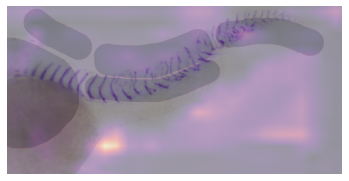

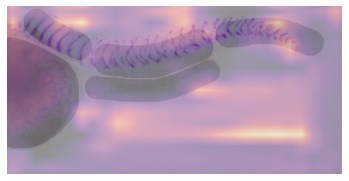

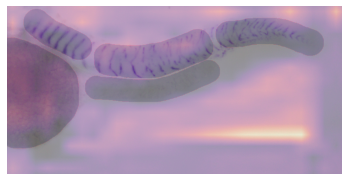

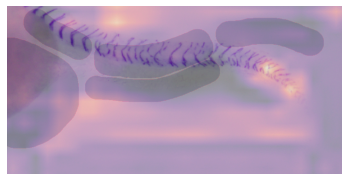

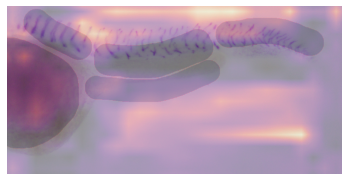

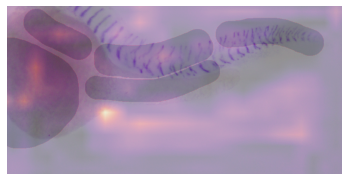

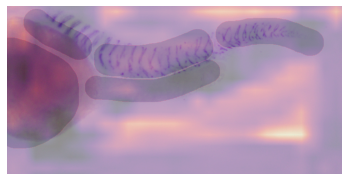

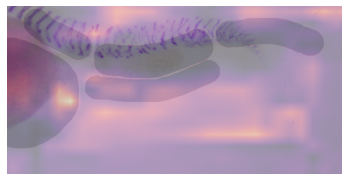

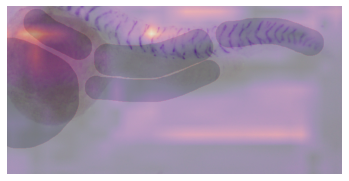

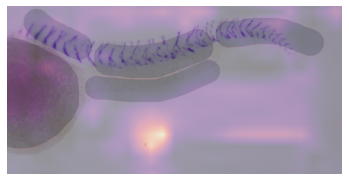

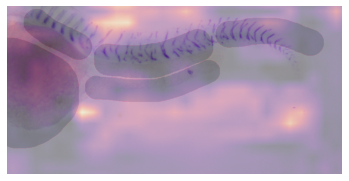

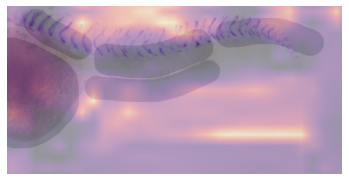

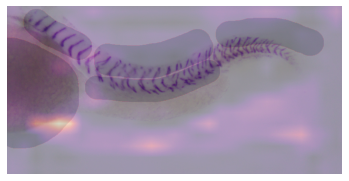

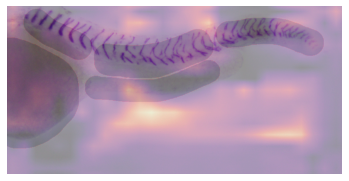

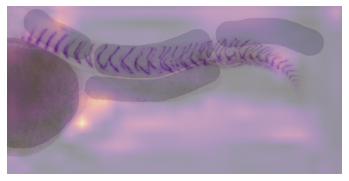

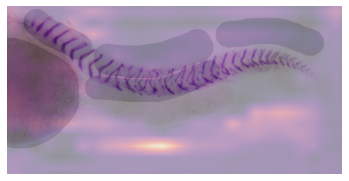

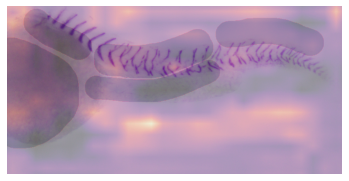

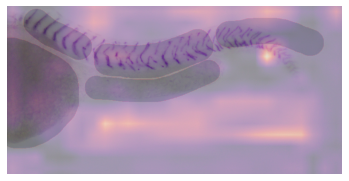

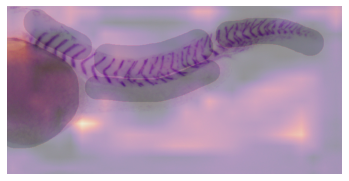

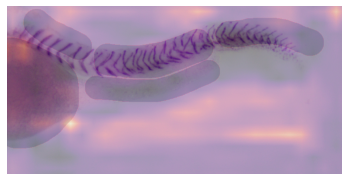

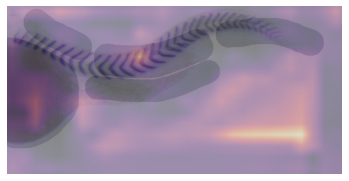

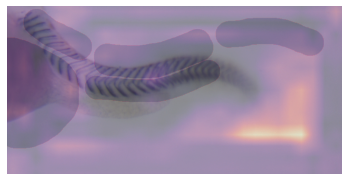

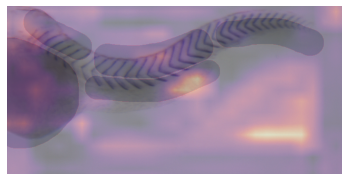

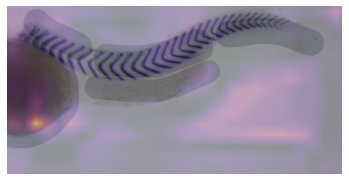

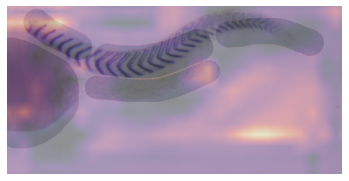

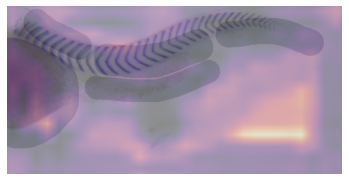

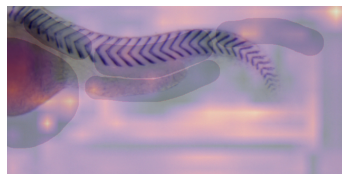

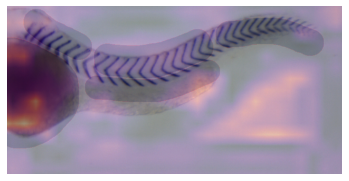

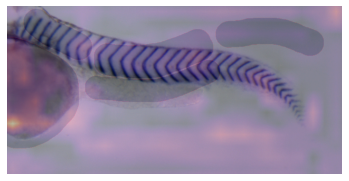

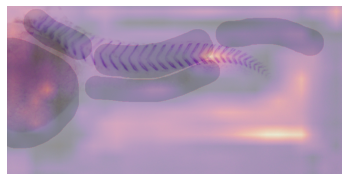

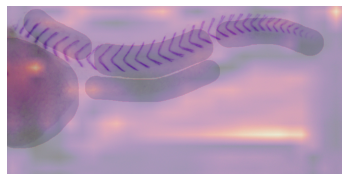

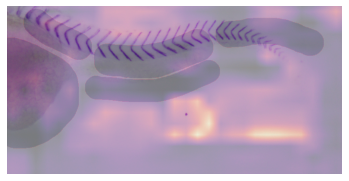

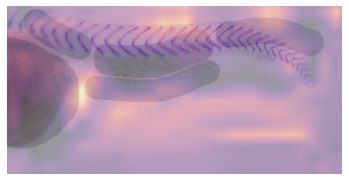

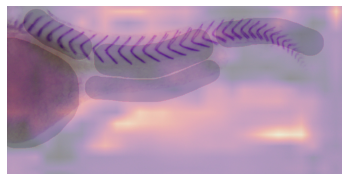

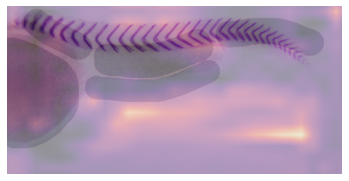

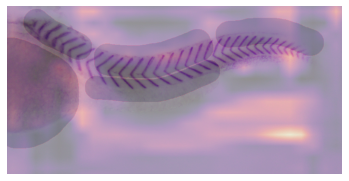

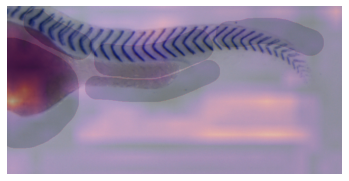

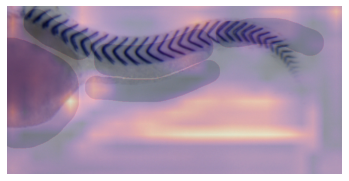

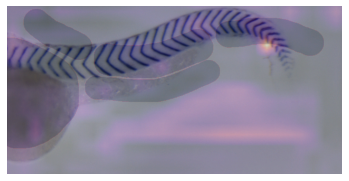

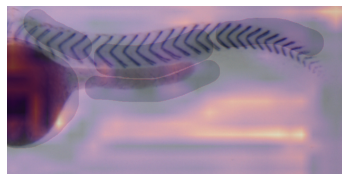

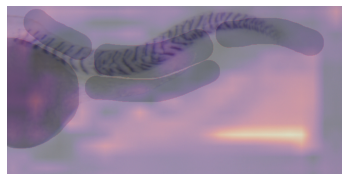

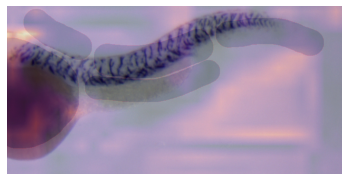

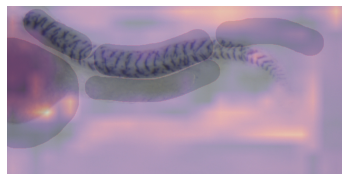

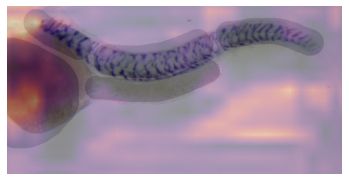

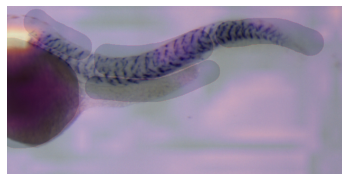

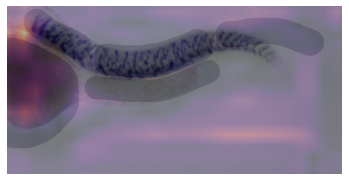

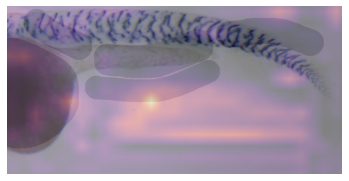

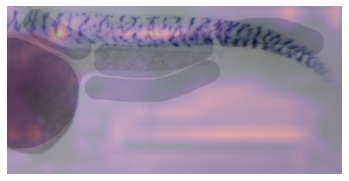

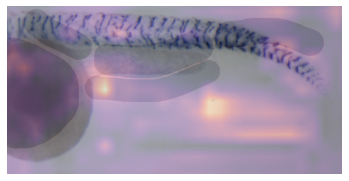

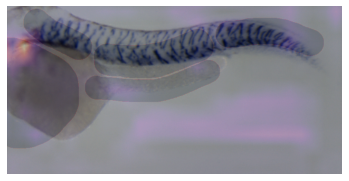

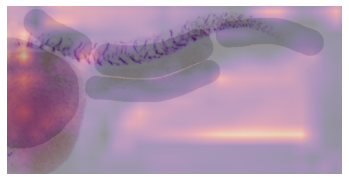

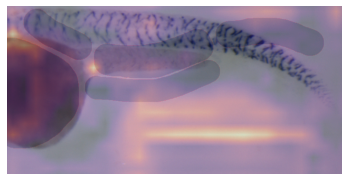

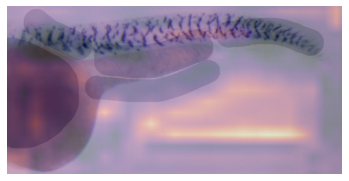

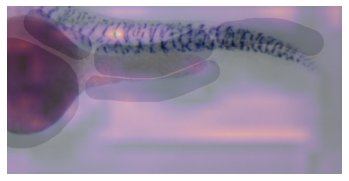

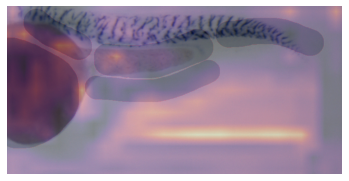

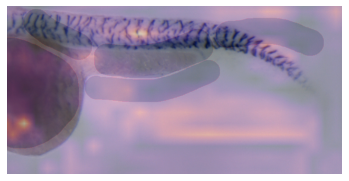

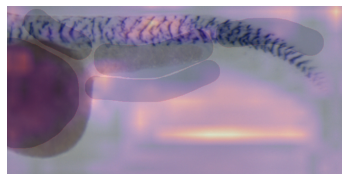

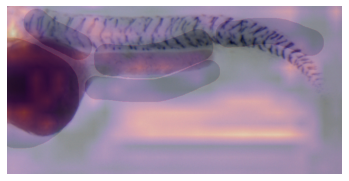

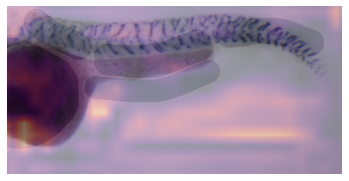

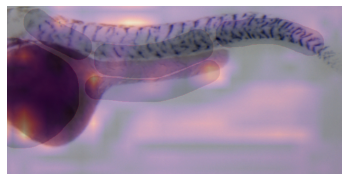

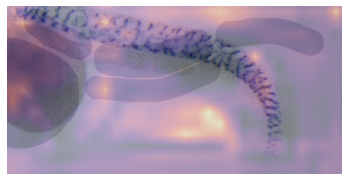

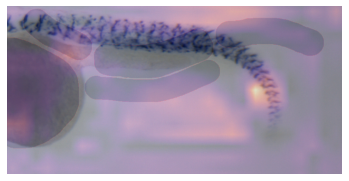

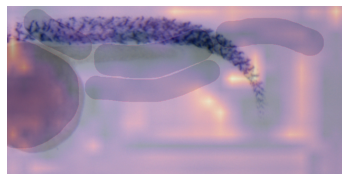

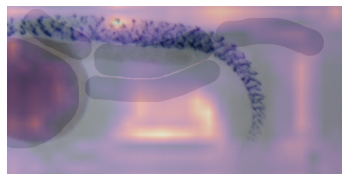

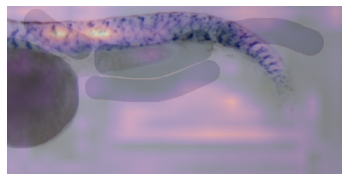

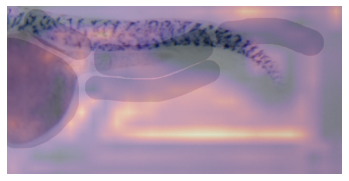

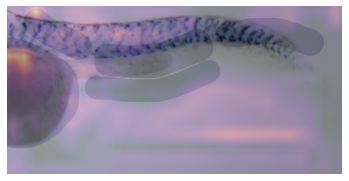

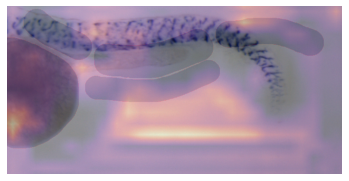

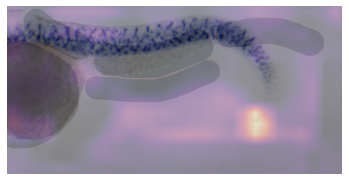

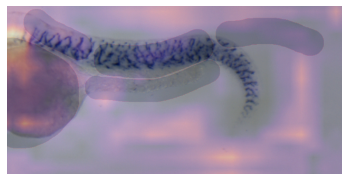

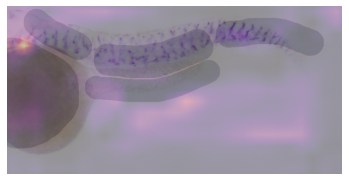

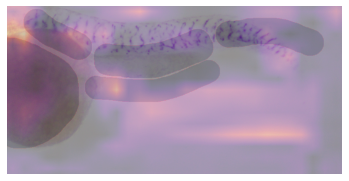

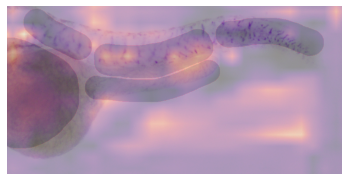

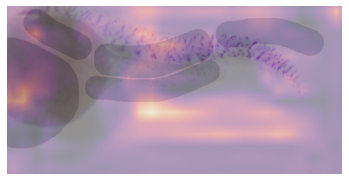

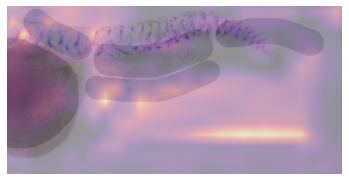

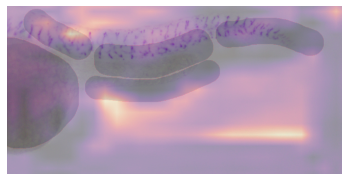

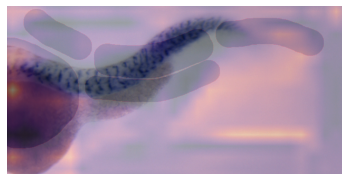

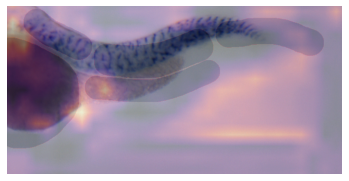

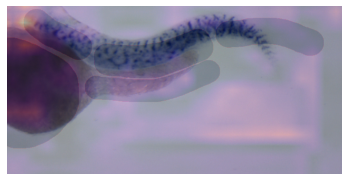

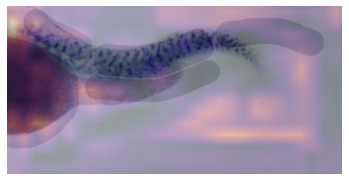

In [61]:
path_val = Path("validation")
val_datagen = ImageDataGenerator( rescale = 1.0/255. ) #no augmentation
data_test = val_datagen.flow_from_directory(path_val,  batch_size = 16, class_mode = 'sparse', target_size = (450, 900), shuffle = False)
#note shuffle = False in the previous line
output_folder = Path("MIL")
classes = []

#saving of the predicted images
if not os.path.exists(output_folder):
        os.mkdir(output_folder)
    
if not os.path.exists(output_folder/"Predictions"):
        os.mkdir(output_folder/"Predictions")   
        
for cl in data_test.class_indices:
    classes.append(cl)
    if os.path.exists(output_folder/"Predictions"/cl):
        shutil.rmtree(output_folder/"Predictions"/cl)
    os.mkdir(output_folder/"Predictions"/cl)

#folder with parts of the fish
folder_parts = Path("fish_part_labels")
filenames = data_test.filenames

total = 0  
for i in range(len(data_test)):
    x, y = data_test.next()
    for j in range(len(x)):
        total = total + 1
        y_pred = np.argmax(model.predict(x[j:j+1]), axis=-1)
        image = x[j:j+1]
        att = model_attention.predict(image)[0,:,:,:]
        y_true = y[j]
        
        filename = filenames[i*16+j].split('.')[0]
        parts_file = glob.glob(str(folder_parts/f"{filename}*"))
        resized_parts = parts.resize((900,450), Image.NEAREST) #everything is streched to the shape of the loaded image
        parts_array = np.array(resized_parts)
        parts_array_binarized = np.where(parts_array > 0, 0, 1)
        
        fig = plt.figure()
        plt.imshow(image[0,...])   
        plt.imshow(resize(att,image.shape[1:3])[:,:,0], alpha=0.4, cmap = 'magma')
        plt.imshow(parts_array_binarized, alpha = 0.1)
        plt.box(False)
        plt.axis('off')
        #fig = resize(att[:,:,0], (450, 900)) - use this and another save funciton to plot the figure for analyzing CAMs
        #print(filenames[i*16+j])
        
          
        if(y_pred == y_true):
            plt.savefig(output_folder/"Predictions"/filenames[i*16+j], dpi = fig.dpi, transparent=True)


### Calculating the per-class- and per-fish-part attention for images from the validation set

In [12]:
def calculate_attention(image, mask, index, normalization = 0):
    
    #index is the value of the part in the mask
    #output is the sum of image pixels on positions mask == image
    #tested on simple examples and it works as expected
    #normalization is the parameter that define
    
    attention = 0
    image.shape
    mask.shape
    if(image.shape != mask.shape):
        print(image.shape)
        print(mask.shape)
        raise Exception('Image and Mask should have the same shape')
    
    #I don't know if there is some trick as in Matlab to do this in two lines of code
    n_pixels = 0
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if(mask[i,j] == index):
                attention = attention + image[i,j]
                n_pixels = n_pixels + 1
                
    if normalization == 1:
        attention = attention / n_pixels 
    return attention

Attention = np.empty((4, 6, 20)) #4 rows are the classes, 5 colums are different zebrafish parts
#indices for zebrafish parts: (in the array as well the values on the zebrafish part paintings)
#0 - background
#1 - head
#2 - trunk
#3 - tail 
#4 - yolk
#5 - yolk extension

#indices for classes are the same as in the classes array

#folder with parts of the fish
folder_parts = Path("fish_parts_labels")

#loading the validation set
path_val = Path("validation")
val_datagen = ImageDataGenerator( rescale = 1.0/255. ) #no augmentation
data_test = val_datagen.flow_from_directory(path_val,  batch_size = 16, class_mode = 'sparse', target_size = (450, 900), shuffle = False)
#note shuffle = False in the previous line
filenames = data_test.filenames

classes = []
for cl in data_test.class_indices:
    classes.append(cl)

class_counter = np.zeros(4) #keeping track of how many images from a certain class there were so far
normalization = 1
for i in range(len(data_test)):
    x, y = data_test.next()
    for j in range(len(x)):
        y_pred = np.argmax(model.predict(x[j:j+1]), axis=-1)
        image = x[j:j+1]
        att = model_attention.predict(image)[0,:,:,:]
        y_true = y[j]
        
        resized_att = np.array(resize(att[:,:,0], image[:2][0,:,:,0].shape))
        #resizing changes values so we scale attention back to 1
        resized_att = resized_att/np.sum(resized_att)
        
        #fig = plt.figure()
        #plt.imshow(att[:,:,0])
        #fig = plt.figure()
        #plt.imshow(resized_att)
        
        for parts_file in glob.glob(folder_parts + '//' + filenames[i*16+j] + '*'):
            parts = Image.open(parts_file)
            resized_parts = parts.resize((900,450), Image.NEAREST) #everything is streched to the shape of the loaded image
            parts_array = np.array(resized_parts)
            for part_index in range(0,6):
                
                Attention[int(y_true), part_index, int(class_counter[int(y_true)])] = calculate_attention(resized_att, parts_array, int(part_index), normalization)
                
        class_counter[int(y_true)] = class_counter[int(y_true)] + 1
        #print(class_counter)

Found 80 images belonging to 4 classes.


### Ploting attention analysis results

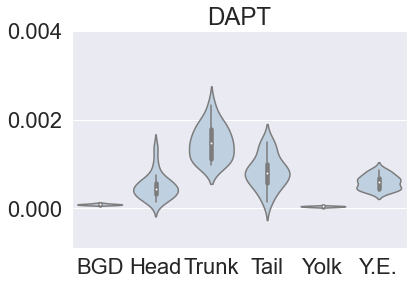

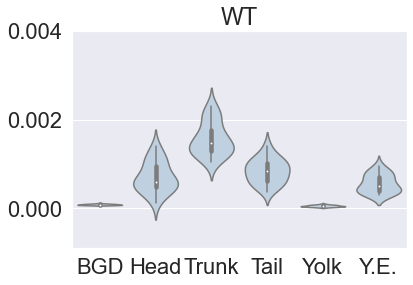

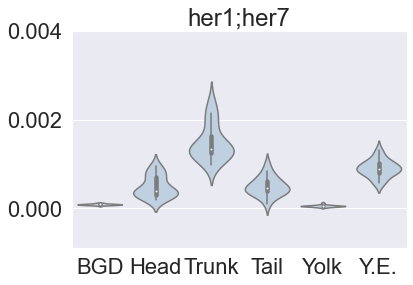

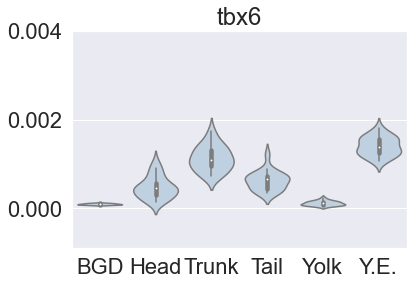

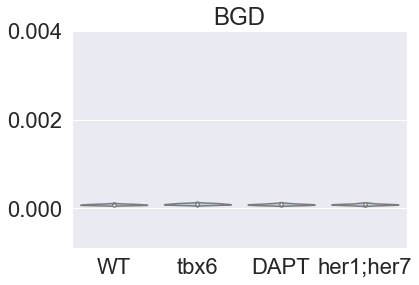

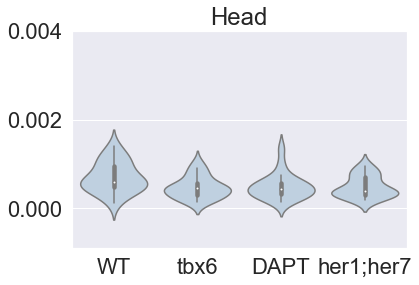

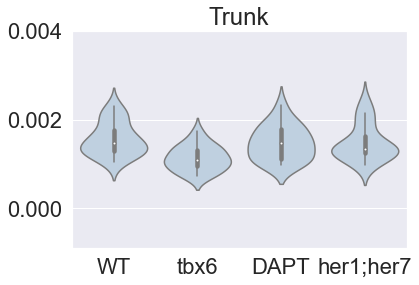

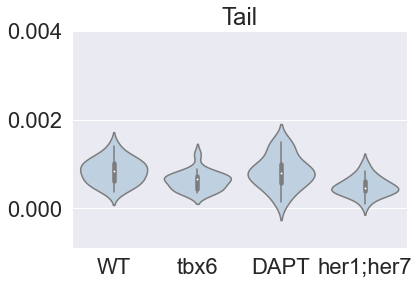

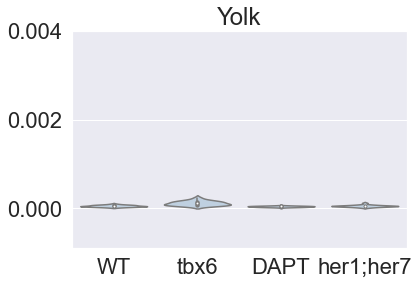

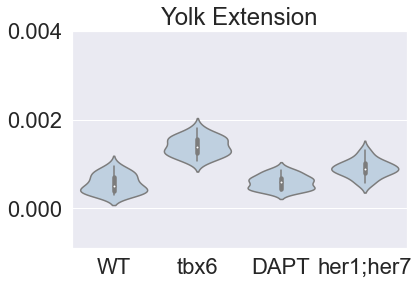

In [30]:
classes_ = ['DAPT', 'WT', 'her1;her7', 'tbx6']
#ploting per class
for i in range(4):
    df = pd.DataFrame({'BGD': Attention[i, 0, :], 'Head': Attention[i, 1, :], 'Trunk': Attention[i, 2, :], 'Tail': Attention[i, 3, :], 'Yolk': Attention[i, 4, :], 'Y.E.': Attention[i, 5, :]})
    plt.figure()
    ax = sns.violinplot(data = df.iloc[:, 0:6]*100, color= np.array([185, 208, 229])/255, scale='width', bw = 'scott') #we scale Y axis so that it represents percentages
    sns.set(font_scale=2)
    #ax.set(ylabel="Attention [%]")
    #plt.yticks([-1, 0, 1, 2, 3, 4, 5, 6])
    plt.ylim([-0.0009, 0.004])
    plt.title(classes_[i])

parts = ['BGD', 'Head', 'Trunk', 'Tail', 'Yolk', 'Yolk Extension']
#ploting per part
for i in range(6):
    df = pd.DataFrame({'WT': Attention[1, i, :], 'tbx6': Attention[3, i, :], 'DAPT': Attention[0, i, :], 'her1;her7': Attention[2, i, :]})
    plt.figure()
    sns.set(font_scale=2)
    ax = sns.violinplot(data = df.iloc[:, 0:6]*100, color= np.array([185, 208, 229])/255, scale='width', bw = 'scott') #we scale Y axis so that it represents percentages
    #ax.set(ylabel="Attention [%]")
    #plt.yticks([-1, 0, 1, 2, 3, 4, 5, 6])
    plt.ylim([-0.0009, 0.004])
    plt.title(parts[i])



### Calculating statistics for attention distribution among different classes

In [13]:
#calculating two-sided p tests for differences in attention

#significance for tail being more important in WT than her1;her7
p = scipy.stats.ttest_ind(Attention[1,3,:], Attention[2,3,:])
print(p.pvalue)
#significance for tail being more important in WT than tbx6
p = scipy.stats.ttest_ind(Attention[1,3,:], Attention[3,3,:])
print(p.pvalue)
#significance for tail being more important in DAPT than tbx6
p = scipy.stats.ttest_ind(Attention[0,3,:], Attention[3,3,:])
print(p.pvalue)

#significance for yolk extension being more important in tbx6 than in the her1;her7
p = scipy.stats.ttest_ind(Attention[3,5,:], Attention[2,5,:])
print(p.pvalue)

0.0008579599018600935
6.735840347340269e-05
0.006156407724921108
1.0853378300423246e-08


### Analyzing the size of the firs parts of different classes

In [30]:
#calculating the parts of the images that are occupied by the fish

#folder with parts of the fish
folder_parts = Path("fish_parts_labels")

fish_occupancy = np.zeros((4,6,20))
#0 - background
#1 - head
#2 - trunk
#3 - tail 
#4 - yolk
#5 - yolk extension

#class order
#0 - DAPT 
#1 - WT
#2 - her1;her7
#3 - tbx6_fss

for cl_i, cl in enumerate(data_test.class_indices):
    for i,image in enumerate(glob.glob(folder_parts + '/' + cl + '/*')):
        parts = np.array(Image.open(image))
        for x in range(parts.shape[0]):
            for y in range(parts.shape[1]):
                pixel_value = parts[x,y]
                fish_occupancy[cl_i, pixel_value, i] = fish_occupancy[cl_i, pixel_value, i] + 1
        fish_occupancy[cl_i, :, i] = fish_occupancy[cl_i, :, i]/parts.size

        
df_fish_occupancy = pd.DataFrame(np.transpose(np.mean(fish_occupancy, axis = 2)), columns = ['DAPT', 'WT', 'her1;her7', 'tbx6_fss'], index = ['BKGD', 'Head', 'Trunk', 'Tail', 'Yolk', 'Y.E.'])
df_fish_occupancy = df_fish_occupancy[['WT', 'tbx6_fss', 'DAPT', 'her1;her7']]
df_fish_occupancy = df_fish_occupancy.rename(columns = {'tbx6_fss':'tbx6'})
#print(df_fish_occupancy['DAPT'])
fig = plt.figure()
ax = df_fish_occupancy.plot.bar(rot=0)